# **Set 5**
**Alireza Haghparast 403416020**

## Cell 1: Setup, Imports, and All Helper Functions
In the first cell, I am defining all of my necessary helper functions in this single setup cell. This **doesn't** includes the neuroCombat function, which I have used in the other notebook.


In [1]:
# --- [CELL 1: SETUP, IMPORTS, AND ALL HELPER FUNCTIONS (No ComBat)] ---
# This cell contains all the necessary helper functions for the analysis,
# but I have removed the neuroCombat function to check the results without
# data harmonization.

# --- 1. Imports ---
import os
import numpy as np
import pandas as pd
from glob import glob
from collections import Counter
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import warnings

# --- 2. Configuration ---
warnings.filterwarnings("ignore")
np.seterr(divide='ignore', invalid='ignore')

# --- 3. HELPER FUNCTIONS ---
def assign_age_group(age):
    """Categorizes a numerical age into one of three developmental groups."""
    if 6 <= age < 9: return "1st Childhood"
    elif 9 <= age < 13: return "2nd Childhood"
    elif 13 <= age <= 18: return "Adolescence"
    else: return None

def compute_signed_fc(corr_matrix):
    """Converts a correlation matrix into a signed network (+1, -1, 0)."""
    signed_matrix = corr_matrix.copy(); np.fill_diagonal(signed_matrix, 0); return np.sign(signed_matrix)

def signed_links(signed_matrix):
    """Calculates statistics about positive and negative links in a network."""
    triu_indices = np.triu_indices_from(signed_matrix, k=1)
    upper_triangle_values = signed_matrix[triu_indices]
    valid_links = upper_triangle_values[~np.isnan(upper_triangle_values)]
    tot_links = len(valid_links); pos_links = np.sum(valid_links == 1); neg_links = np.sum(valid_links == -1)
    return {"tot_links": tot_links, "pos_links": pos_links, "neg_links": neg_links}

def count_triads(signed_matrix):
    """Counts the occurrences of the four triad types (T0, T1, T2, T3) in a network."""
    N = signed_matrix.shape[0]; triads = {"T0": 0, "T1": 0, "T2": 0, "T3": 0};
    if N < 3: return triads
    for i in range(N):
        for j in range(i + 1, N):
            for k in range(j + 1, N):
                w1, w2, w3 = signed_matrix[i, j], signed_matrix[j, k], signed_matrix[k, i]
                if (w1 != 0 and w2 != 0 and w3 != 0) and not (np.isnan(w1) or np.isnan(w2) or np.isnan(w3)):
                    s = sum(1 for val in [w1, w2, w3] if val == -1)
                    if s == 0: triads["T3"] += 1
                    elif s == 1: triads["T2"] += 1
                    elif s == 2: triads["T1"] += 1
                    elif s == 3: triads["T0"] += 1
    return triads

def calculate_network_energy(triad_counts):
    """Calculates the overall structural balance energy of a network."""
    balanced = triad_counts.get("T3", 0) + triad_counts.get("T1", 0)
    imbalanced = triad_counts.get("T2", 0) + triad_counts.get("T0", 0)
    total_triads = balanced + imbalanced
    if total_triads == 0: return np.nan
    return (imbalanced - balanced) / total_triads

def get_continuous_triad_energy_distributions(continuous_corr_matrix, signed_matrix_for_type):
    """Calculates the continuous energy value (product of weights) for each T0 and T1 triad."""
    N = continuous_corr_matrix.shape[0]; energies = {"T0_energies": [], "T1_energies": []}
    if N < 3: return energies
    for i in range(N):
        for j in range(i + 1, N):
            for k in range(j + 1, N):
                w_cont_ij, w_cont_jk, w_cont_ki = continuous_corr_matrix[i, j], continuous_corr_matrix[j, k], continuous_corr_matrix[k, i]
                s_ij, s_jk, s_ki = signed_matrix_for_type[i, j], signed_matrix_for_type[j, k], signed_matrix_for_type[k, i]
                if np.isnan(w_cont_ij) or np.isnan(w_cont_jk) or np.isnan(w_cont_ki) or s_ij == 0 or s_jk == 0 or s_ki == 0: continue
                energy_val = w_cont_ij * w_cont_jk * w_cont_ki
                neg_links = sum(1 for s in [s_ij, s_jk, s_ki] if s == -1)
                if neg_links == 3: energies["T0_energies"].append(energy_val)
                elif neg_links == 2: energies["T1_energies"].append(energy_val)
    return energies

print("All helper functions defined (without ComBat).")


All helper functions defined (without ComBat).


## Cell 2: Complete Data Processing Pipeline

This cell contains the main data processing pipeline for my analysis. It performs all the necessary steps from start to finish to create the final, clean dataset that I will use for my subsequent statistical analyses and plots. The pipeline aligns as closely as possible with the methodology from the reference paper and includes the following key steps:

1.  **Creation of connectivity matrices** from my raw time series data (`.1D` files).
2.  **Handling of missing data** (`-9999` values) and **data homogenization** to ensure all subjects have a uniform data shape.
3.  **Statistical thresholding** to define significant brain connections (edges), which is a key step from the paper's methods.
4.  **Calculation of all final metrics** (triad counts, energies, link stats, etc.) from the cleaned and harmonized data.
5.  **Saving a clean, final DataFrame** and the separate energy lists for later use in plotting.

In [ ]:
# --- [DATA PROCESSING CELL - WITHOUT HARMONIZATION] ---
# This cell performs the entire data preparation pipeline, but intentionally
# skips the ComBat harmonization step to allow for comparison of results.

# --- 1. KAGGLE FILE PATHS AND SETUP ---
print("--- Setting up file paths for Kaggle ---")
KAGGLE_INPUT_DIR = '/kaggle/input/abide-preprocessed-data' 
TIME_SERIES_DIR = os.path.join(KAGGLE_INPUT_DIR, 'filt_noglobal', 'filt_noglobal')
PHENO_FILE = os.path.join(KAGGLE_INPUT_DIR, 'Phenotypic_V1_0b_preprocessed1.csv')
OUTPUT_DIR_KAGGLE = '/kaggle/working/'
FC_DIR_KAGGLE = os.path.join(OUTPUT_DIR_KAGGLE, 'fc')
# Save energy lists to a different directory to avoid overwriting harmonized results
ENERGY_LISTS_DIR = os.path.join(OUTPUT_DIR_KAGGLE, 'energy_lists_unharmonized') 
os.makedirs(FC_DIR_KAGGLE, exist_ok=True)
os.makedirs(ENERGY_LISTS_DIR, exist_ok=True)

# --- 2. CREATE CORRELATION MATRICES FROM .1D FILES ---
print(f"\n--- Creating correlation matrices from .1D files ---")
files_1d = sorted(glob(os.path.join(TIME_SERIES_DIR, '*.1D')))
if not files_1d:
    raise FileNotFoundError(f"CRITICAL ERROR: No .1D files found in {TIME_SERIES_DIR}.")
def process_1d_file(filepath):
    try:
        data = np.loadtxt(filepath)
        if data.shape[0] < data.shape[1]: data = data.T
        return np.corrcoef(data.T)
    except: return None
for filepath in tqdm(files_1d, desc="Creating Correlation Matrices"):
    filename = os.path.splitext(os.path.basename(filepath))[0]
    corr_matrix = process_1d_file(filepath)
    if corr_matrix is not None:
        pd.DataFrame(corr_matrix).to_csv(os.path.join(FC_DIR_KAGGLE, f'{filename}_connectivity.csv'), index=False)
print(f"Finished creating {len(glob(os.path.join(FC_DIR_KAGGLE, '*.csv')))} connectivity matrices.")

# --- 3. LOAD, CLEAN, & HOMOGENIZE DATA ---
print("\n--- Loading, cleaning, and homogenizing data ---")
# Load the phenotype file, treating -9999 as missing data
df_pheno = pd.read_csv(PHENO_FILE, na_values=[-9999])
df_pheno['SUB_ID'] = df_pheno['SUB_ID'].apply(lambda x: f'{x:07d}')
fc_files = sorted(glob(os.path.join(FC_DIR_KAGGLE, '*_connectivity.csv')))
subject_id_to_fc_path = {os.path.basename(f).split('_')[1]: f for f in fc_files}
df_pheno_filtered = df_pheno[df_pheno['SUB_ID'].isin(subject_id_to_fc_path.keys())].copy()
# This line defines the all_subjects_data variable
all_subjects_data = [{'sub_id': row['SUB_ID'], 'matrix': pd.read_csv(subject_id_to_fc_path[row['SUB_ID']]).values} for _, row in df_pheno_filtered.iterrows()]
most_common_shape = Counter(s['matrix'].shape for s in all_subjects_data).most_common(1)[0][0]
all_subjects_data = [s for s in all_subjects_data if s['matrix'].shape == most_common_shape]
n_nodes = most_common_shape[0]
print(f"Dataset homogenized to {len(all_subjects_data)} subjects with shape {most_common_shape}.")


# --- 4. STATISTICAL THRESHOLDING FOR EDGES ---
print("\n--- Creating group-level significance mask for edges ---")
stacked_matrices = np.array([s['matrix'] for s in all_subjects_data])
z_transformed = np.arctanh(np.clip(stacked_matrices, -0.999, 0.999))
triu_indices = np.triu_indices(n_nodes, k=1)
edge_data_for_test = z_transformed[:, triu_indices[0], triu_indices[1]]
_, p_values = ttest_1samp(edge_data_for_test, 0, axis=0)
reject, _, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')
significance_mask = np.zeros((n_nodes, n_nodes), dtype=bool)
significance_mask[triu_indices] = reject
significance_mask = significance_mask + significance_mask.T
print(f"Edge mask created. Found {reject.sum()} significant edges to be used in the analysis.")

# --- 5. FINAL METRICS CALCULATION (Worker function definition) ---
# This worker function is simplified as it no longer uses harmonized data.
def process_unharmonized_data(subject_data):
    """
    Worker function for the parallel loop. Processes the original, thresholded
    matrix for a single subject to calculate all final metrics.
    """
    try:
        sub_id = subject_data['sub_id']
        original_matrix = subject_data['matrix']
        
        # Apply the group-level significance mask
        thresholded_matrix = original_matrix * significance_mask
        
        # Create the signed version from the thresholded matrix
        signed_matrix = compute_signed_fc(thresholded_matrix)
        
        # Calculate all metrics
        triad_counts = count_triads(signed_matrix)
        link_stats = signed_links(signed_matrix)
        energy_whole_brain = calculate_network_energy(triad_counts)
        continuous_triad_energies = get_continuous_triad_energy_distributions(thresholded_matrix, signed_matrix)
        nodes_sn_a, nodes_dmn_b = list(range(34)), list(range(34, 66))
        energy_sn_a = calculate_network_energy(count_triads(signed_matrix[np.ix_(nodes_sn_a, nodes_sn_a)]))
        energy_dmn_b = calculate_network_energy(count_triads(signed_matrix[np.ix_(nodes_dmn_b, nodes_dmn_b)]))
        
        # Save lists to separate files
        np.save(os.path.join(ENERGY_LISTS_DIR, f"{sub_id}_T0_unharm.npy"), np.array(continuous_triad_energies["T0_energies"]))
        np.save(os.path.join(ENERGY_LISTS_DIR, f"{sub_id}_T1_unharm.npy"), np.array(continuous_triad_energies["T1_energies"]))
        
        # Get phenotype data for this subject
        pheno_row = df_pheno_filtered.loc[df_pheno_filtered['SUB_ID'] == sub_id].iloc[0]

        # Return dictionary of scalar values
        return {"SUB_ID": sub_id, "Group": "ASD" if pheno_row['DX_GROUP'] == 1 else "CON", "AgeGroup": assign_age_group(pheno_row['AGE_AT_SCAN']), **pheno_row, **triad_counts, **link_stats, "Energy_Whole_Brain": energy_whole_brain, "Energy_SN_A": energy_sn_a, "Energy_DMN_B": energy_dmn_b}
    except Exception as e:
        print(f"Error processing subject {subject_data.get('sub_id', 'UNKNOWN')}: {e}")
        return None

# --- 6. RUN PARALLEL METRIC CALCULATION ---
print("\nCalculating all final metrics in parallel (without harmonization)...")
# The loop now iterates over the correctly defined 'all_subjects_data'
final_results_list = Parallel(n_jobs=-1)(
    delayed(process_unharmonized_data)(subj_data) 
    for subj_data in tqdm(all_subjects_data, desc="Calculating Unharmonized Metrics")
)

# --- 7. SAVE FINAL DATAFRAME ---
df_analysis_unharmonized = pd.DataFrame([r for r in final_results_list if r is not None])
# Save with a new name to distinguish it from the harmonized version
output_pkl_path = os.path.join(OUTPUT_DIR_KAGGLE, 'df_analysis_final_unharmonized.pkl')
df_analysis_unharmonized.to_pickle(output_pkl_path)
print(f"\nProcessing complete. UNHARMONIZED DataFrame saved to: {output_pkl_path}")
display(df_analysis_unharmonized.head())


--- Setting up file paths for Kaggle ---

--- Creating correlation matrices from .1D files ---


Creating Correlation Matrices:   0%|          | 0/1035 [00:00<?, ?it/s]

Finished creating 1035 connectivity matrices.

--- Loading, cleaning, and homogenizing data ---
Dataset homogenized to 227 subjects with shape (176, 176).

--- Creating group-level significance mask for edges ---
Edge mask created. Found 2394 significant edges to be used in the analysis.

Calculating all final metrics in parallel (without harmonization)...


Calculating Unharmonized Metrics:   0%|          | 0/227 [00:00<?, ?it/s]

## Cell 3: Load Final Harmonized Data

In this cell, I am loading the final, clean, and harmonized DataFrame that was created and saved by the main data processing script (Cell 2). This `df_analysis_final_unharmonized.pkl` file contains all the scalar metrics (like triad counts and network energy) needed for my subsequent analyses. Loading this pre-computed file means I do not have to re-run the time-consuming data preparation steps every time I want to create a plot or table. This cell also defines the file paths for the output directory and the separate `.npy` energy lists that will be used by the plotting cells.

In [7]:
# --- [CELL 3: LOAD FINAL DATA] ---

# Import necessary libraries for file operations and plotting
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define the output directory where figures will be saved
OUTPUT_DIR_KAGGLE = '/kaggle/working/'
# The directory where the large lists of triad energies were saved as separate files
ENERGY_LISTS_DIR = os.path.join(OUTPUT_DIR_KAGGLE, 'energy_lists_unharmonized')

# Load the final harmonized data using a try-except block for robust error handling
try:
    # Define the full path to the saved pickle file
    data_path = os.path.join(OUTPUT_DIR_KAGGLE, 'df_analysis_final_unharmonized.pkl')
    # Load the DataFrame from the pickle file. This is fast and preserves data types.
    df_analysis = pd.read_pickle(data_path)
    # Print a confirmation message to the user
    print("Successfully loaded the final unharmonized DataFrame.")
    print(f"DataFrame shape: {df_analysis.shape}")
# If the file is not found, raise a clear error telling the user what to do next
except FileNotFoundError:
    raise FileNotFoundError("Could not find 'df_analysis_final.pkl'. Please run the main data processing cell first.")



Successfully loaded the final unharmonized DataFrame.
DataFrame shape: (227, 118)


## Cell 4: Generate Table 1 (Triad Probabilities & Surprise)
In this cell, I am replicating the analysis for Table 1 from the paper. The purpose of this analysis is to test the Structural Balance Theory, which predicts that balanced triads will be overrepresented and unbalanced triads will be underrepresented compared to what would be expected by random chance.

To do this, I first run a "null model" which creates thousands of random networks that have the same number of positive and negative links as my real data. This tells me the triad frequencies that would occur by chance.

I then compare the triad probabilities from my real data (p(Ti)) to the null model's probabilities (p0(Ti)) by calculating a "surprise" metric, s(Ti). A large positive surprise means the triad is overrepresented, and a large negative surprise means it is underrepresented.

In [8]:
# --- [Cell 4: Generate Table 1 (Triad Probabilities & Surprise)] ---

# Helper functions needed for the null model
def count_triads(signed_matrix):
    """Counts the occurrences of the four triad types (T0, T1, T2, T3) in a network."""
    N = signed_matrix.shape[0]
    triads = {"T0": 0, "T1": 0, "T2": 0, "T3": 0}
    if N < 3: return triads
    # Efficiently iterate through unique triplets of nodes
    for i in range(N):
        for j in range(i + 1, N):
            for k in range(j + 1, N):
                w1, w2, w3 = signed_matrix[i, j], signed_matrix[j, k], signed_matrix[k, i]
                if (w1 != 0 and w2 != 0 and w3 != 0) and not (np.isnan(w1) or np.isnan(w2) or np.isnan(w3)):
                    # Count negative links to determine triad type
                    s = sum(1 for val in [w1, w2, w3] if val == -1)
                    if s == 0: triads["T3"] += 1
                    elif s == 1: triads["T2"] += 1
                    elif s == 2: triads["T1"] += 1
                    elif s == 3: triads["T0"] += 1
    return triads

def run_null_trial(n_nodes, pos_links_count, neg_links_count):
    """Creates a single random network and counts its triads for the null model."""
    num_total_links = pos_links_count + neg_links_count
    if num_total_links == 0: return {"T0":0, "T1":0, "T2":0, "T3":0}, 0
    # Create a pool of positive (+1) and negative (-1) links and shuffle them
    shuffled_signs = np.array([1] * pos_links_count + [-1] * neg_links_count)
    np.random.shuffle(shuffled_signs)
    null_matrix = np.zeros((n_nodes, n_nodes))
    triu_indices = np.triu_indices(n_nodes, k=1)
    
    # Place shuffled links randomly onto the empty matrix
    if len(shuffled_signs) != len(triu_indices[0]):
        link_indices = np.random.choice(len(triu_indices[0]), size=num_total_links, replace=False)
        for i, link_idx in enumerate(link_indices):
            r, c = triu_indices[0][link_idx], triu_indices[1][link_idx]
            null_matrix[r, c] = shuffled_signs[i]
    else:
        null_matrix[triu_indices] = shuffled_signs

    null_matrix += null_matrix.T # Make the matrix symmetric
    null_triads = count_triads(null_matrix)
    return null_triads, sum(null_triads.values())

def null_model_parallel(n_nodes, num_trials, pos_links, neg_links):
    """Runs many null trials in parallel to generate a stable distribution."""
    results = Parallel(n_jobs=-1)(
        delayed(run_null_trial)(n_nodes, pos_links, neg_links) 
        for _ in tqdm(range(num_trials), desc="Running Null Model")
    )
    # Calculate probabilities for each triad type from the results
    probs = {f"T{i}": [] for i in range(4)}
    for triads, total in results:
        if total > 0:
            for i in range(4): probs[f"T{i}"].append(triads[f"T{i}"] / total)
    
    # Return the mean and standard deviation of the null probabilities
    return {f"T{i}": (np.mean(probs[f"T{i}"]), np.std(probs[f"T{i}"])) for i in range(4)}


# This block executes the analysis for Table 1
if 'df_analysis' in locals():
    # Calculate mean counts from my real data
    summary_mean_counts = df_analysis.groupby(['Group', 'AgeGroup'], observed=True)[['T0', 'T1', 'T2', 'T3']].mean(numeric_only=True)
    
    # Get parameters needed for the null model from the real data
    n_nodes = 196 # Based on my cc200 atlas
    avg_pos_links = int(df_analysis['pos_links'].mean())
    avg_neg_links = int(df_analysis['neg_links'].mean())
    
    print(f"\nUsing N_NODES = {n_nodes} for null model.")
    print(f"Null model will preserve average positive links: {avg_pos_links}, average negative links: {avg_neg_links}.")
    
    # Run the null model simulation
    null_stats = null_model_parallel(n_nodes, 1000, avg_pos_links, avg_neg_links)

    # Calculate p(Ti) (observed probability) and s(Ti) (surprise)
    summary_mean_counts['Total_Triads'] = summary_mean_counts.sum(axis=1)
    p_ti_results = pd.DataFrame(index=summary_mean_counts.index)
    s_ti_results = pd.DataFrame(index=summary_mean_counts.index)

    for triad_type in ['T0', 'T1', 'T2', 'T3']:
        p_ti_results[triad_type] = summary_mean_counts[triad_type] / summary_mean_counts['Total_Triads']
        if triad_type in null_stats and null_stats[triad_type][1] != 0:
            p0_mean, p0_std = null_stats[triad_type]
            s_ti_results[triad_type] = (p_ti_results[triad_type] - p0_mean) / p0_std
        else:
            s_ti_results[triad_type] = np.nan

    # --- Print the final tables ---
    print("\n--- Replicated Table 1: p(Ti) (Fraction of Triads) ---")
    print(p_ti_results.to_string(float_format="%.4f"))

    print("\n--- Replicated Table 1: s(Ti) (Surprise Measure) ---")
    print(s_ti_results.to_string(float_format="%.2f"))



Using N_NODES = 196 for null model.
Null model will preserve average positive links: 929, average negative links: 1464.


Running Null Model:   0%|          | 0/1000 [00:00<?, ?it/s]


--- Replicated Table 1: p(Ti) (Fraction of Triads) ---
                        T0     T1     T2     T3
Group AgeGroup                                 
ASD   1st Childhood 0.1816 0.5464 0.1758 0.0962
      2nd Childhood 0.1730 0.5482 0.1785 0.1003
      Adolescence   0.1622 0.5572 0.1745 0.1061
CON   1st Childhood 0.1713 0.5559 0.1715 0.1013
      2nd Childhood 0.1648 0.5566 0.1725 0.1060
      Adolescence   0.1670 0.5549 0.1733 0.1047

--- Replicated Table 1: s(Ti) (Surprise Measure) ---
                       T0    T1     T2    T3
Group AgeGroup                              
ASD   1st Childhood -5.66 11.00 -10.94  7.95
      2nd Childhood -6.68 11.18 -10.64  8.81
      Adolescence   -7.97 12.08 -11.08 10.03
CON   1st Childhood -6.88 11.94 -11.41  9.03
      2nd Childhood -7.65 12.02 -11.29 10.02
      Adolescence   -7.39 11.85 -11.21  9.75


## Cell 5: Generate Table 2 (ANCOVA Results)

In this cell, I replicate the statistical analysis for Table 2 from the paper. The goal is to determine if there are significant differences in the frequencies of links and triads between the ASD and CON groups, and if these differences change across the developmental age groups.

To do this, I run a series of two-way ANCOVA (Analysis of Covariance) tests. For each metric (e.g., `pos_links`, `T0`, `T1`, etc.), I fit a model that looks for effects of `Group` and a `Group x Age` interaction, while statistically controlling for potential confounding variables like the scanner `SITE_ID`, `FIQ`, and head motion (`func_mean_fd`).

The final output is a consolidated pivot table that summarizes the `p-value` and `Partial Eta Squared` (a measure of effect size) for the main effects, mirroring the format in the paper.

In [9]:
# --- [CELL 5: GENERATE TABLE 2 - ANCOVA RESULTS] ---

# Import the necessary functions for statistical modeling
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import pandas as pd
import os

# Define the output directory where files are located
OUTPUT_DIR_KAGGLE = '/kaggle/working/'

# Load the final harmonized dataframe created by the main processing cell
try:
    df_analysis = pd.read_pickle(os.path.join(OUTPUT_DIR_KAGGLE, 'df_analysis_final_unharmonized.pkl'))
    print("Successfully loaded harmonized data for Table 2 analysis.")
except FileNotFoundError:
    raise FileNotFoundError("Could not find 'df_analysis_final_unharmonized.pkl'. Please run the main data processing cell first.")

# This block executes the analysis for Table 2
if 'df_analysis' in locals():
    # Initialize a list to store the results from each ANCOVA run
    ancova_results = []
    
    # Define the dependent variables (metrics) to be tested, as per the paper
    dependent_vars = ['pos_links', 'neg_links', 'T0', 'T1', 'T2', 'T3'] 

    # Loop through each metric and run a separate ANCOVA
    for dep_var in dependent_vars:
        # Check if the column exists in the DataFrame to prevent errors
        if dep_var not in df_analysis.columns:
            print(f"Warning: Column '{dep_var}' not found in DataFrame. Skipping.")
            continue
            
        print(f"\n--- ANCOVA results for {dep_var} ---")
        
        # This tests for the main effects of Group and AgeGroup, their interaction,
        # while controlling for SITE_ID, FIQ, and func_mean_fd as covariates.
        formula = f"{dep_var} ~ C(Group) + C(AgeGroup) + C(SITE_ID) + C(Group):C(AgeGroup) + FIQ + func_mean_fd"
        
        try:
            # Fit the Ordinary Least Squares (OLS) model based on the formula
            model = ols(formula, data=df_analysis).fit()
            # Generate the ANCOVA table from the fitted model (Type 2 sum of squares)
            anova_table = anova_lm(model, typ=2)
            
            # Extract and store the key results (p-value and effect size) for the summary table
            for effect in ['C(Group)', 'C(Group):C(AgeGroup)']:
                ss_effect = anova_table.loc[effect, 'sum_sq']
                ss_residual = anova_table.loc['Residual', 'sum_sq']
                ancova_results.append({
                    'Dependent Variable': dep_var,
                    'Source': 'Group' if effect == 'C(Group)' else 'Group x Age', # Rename for clarity
                    'p-value': anova_table.loc[effect, 'PR(>F)'],
                    'Partial Eta Squared': ss_effect / (ss_effect + ss_residual) # Calculate effect size
                })

        except Exception as e:
            print(f"Error running ANCOVA for {dep_var}: {e}")

    # --- Print the final consolidated summary table ---
    if ancova_results:
        df_table2_summary = pd.DataFrame(ancova_results)
        print("\n\n--- Consolidated Table 2 (Group and Group x Age Interaction Effects) ---")
        
        # Create a pivot table to format the results nicely, similar to the paper's table
        summary_pivot = df_table2_summary.pivot_table(
            index='Dependent Variable', 
            columns='Source', 
            values=['p-value', 'Partial Eta Squared']
        )
        print(summary_pivot.to_string(float_format="%.3f"))


Successfully loaded harmonized data for Table 2 analysis.

--- ANCOVA results for pos_links ---

--- ANCOVA results for neg_links ---

--- ANCOVA results for T0 ---

--- ANCOVA results for T1 ---

--- ANCOVA results for T2 ---

--- ANCOVA results for T3 ---


--- Consolidated Table 2 (Group and Group x Age Interaction Effects) ---
                   Partial Eta Squared             p-value            
Source                           Group Group x Age   Group Group x Age
Dependent Variable                                                    
T0                               0.001       0.020   0.616       0.186
T1                               0.006       0.021   0.304       0.160
T2                               0.008       0.004   0.245       0.712
T3                               0.003       0.008   0.475       0.501
neg_links                        0.000       0.003   0.944       0.781
pos_links                        0.000       0.003   0.944       0.781


## Cell 6: Calculate Post-Hoc Statistics for Figure 1 Annotations

In this cell, I calculate the specific statistics needed to create the annotations for Figure 1, as seen in the paper. While my main ANCOVA (Table 2) tells me if there are overall significant effects, it doesn't provide the comparison for each individual age group.

To get these values, I perform "post-hoc tests." Following the paper's methodology, this script runs a **Mann-Whitney U test** to compare the ASD and CON groups within each of the three age categories (`1st Childhood`, `2nd Childhood`, `Adolescence`) for every metric.

For each comparison, I calculate:
1.  The **p-value**, which I will use to determine the significance stars (`*` or `**`).
2.  The **Partial Eta Squared (`η²`)**, which is a measure of effect size.

The results are stored in dictionaries (`post_hoc_p_values`, `post_hoc_eta2`) so they can be automatically added to the Figure 1 plots in the next step.

In [10]:
# --- [CELL 6: CALCULATE POST-HOC STATISTICS FOR FIGURE 1] ---

# Import the specific statistical test we need from the scipy library
from scipy.stats import mannwhitneyu
import numpy as np # Ensure numpy is imported

# Check if the main df_analysis DataFrame is loaded into memory
if 'df_analysis' not in locals():
    raise NameError("df_analysis not found. Please load the final DataFrame first.")

# --- Data Preparation ---
# Before running stats, it's good practice to ensure the 'AgeGroup' column is a
# pandas 'Categorical' type. This ensures the correct order for looping.
age_group_order = ['1st Childhood', '2nd Childhood', 'Adolescence']
df_analysis['AgeGroup'] = pd.Categorical(df_analysis['AgeGroup'], categories=age_group_order, ordered=True)

# --- Initialize Dictionaries to Store Results ---
# These dictionaries will hold the calculated p-value and eta-squared for each comparison
post_hoc_p_values = {}
post_hoc_eta2 = {}

# Define the list of metrics we need to test for Figure 1
metrics_for_fig1 = ['pos_links', 'neg_links', 'T0', 'T1', 'T2', 'T3']
# Get the unique, ordered list of age groups to loop through
age_groups = df_analysis['AgeGroup'].cat.categories.tolist()

print("Running post-hoc tests for each metric and age group...")

# --- Main Loop to Perform Statistical Tests ---
# Outer loop: iterate through each metric (e.g., 'pos_links', 'T0', etc.)
for metric in metrics_for_fig1:
    # Initialize nested dictionaries for this specific metric
    post_hoc_p_values[metric] = {}
    post_hoc_eta2[metric] = {}
    
    # Inner loop: iterate through each age group (e.g., '1st Childhood')
    for age in age_groups:
        # Filter the DataFrame to get the data for the ASD group for the current age and metric
        group_asd = df_analysis[(df_analysis['AgeGroup'] == age) & (df_analysis['Group'] == 'ASD')][metric]
        # Filter the DataFrame to get the data for the CON group for the current age and metric
        group_con = df_analysis[(df_analysis['AgeGroup'] == age) & (df_analysis['Group'] == 'CON')][metric]
        
        # Ensure there is data for both groups before running the test
        if len(group_asd) > 0 and len(group_con) > 0:
            # Perform the Mann-Whitney U test, which compares the two independent groups
            u_stat, p_val = mannwhitneyu(group_asd, group_con, alternative='two-sided')
            
            # Calculate the effect size (eta-squared) from the test results
            n1, n2 = len(group_asd), len(group_con)
            # Convert the U statistic to a Z-score
            z_stat = (u_stat - (n1 * n2 / 2)) / np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
            # Calculate eta-squared from the Z-score
            eta2 = z_stat**2 / (n1 + n2 - 1)
            
            # Store the calculated p-value and eta-squared in the dictionaries
            post_hoc_p_values[metric][age] = p_val
            post_hoc_eta2[metric][age] = eta2
        else:
            # If there's no data for one of the groups, store placeholder values
            post_hoc_p_values[metric][age] = 1.0 # p-value of 1.0 means not significant
            post_hoc_eta2[metric][age] = 0.0

print("Post-hoc statistical tests complete.")
print("You can now proceed to the plotting cells for Figure 1.")



Running post-hoc tests for each metric and age group...
Post-hoc statistical tests complete.
You can now proceed to the plotting cells for Figure 1.


## Cell 7: Generate Figure 1A (Link Frequencies)

In this cell, I create the first part of Figure 1 from the paper, which visualizes the mean frequencies of positive and negative links across the different age groups.

The process for each subplot is as follows:
1.  I group my final harmonized `df_analysis` DataFrame to get the mean and standard error of the mean (SEM) for each group and age.
2.  I use `matplotlib`'s `bar` function to manually plot the bars for the CON and ASD groups. This gives me precise control over their width and position.
3.  I then plot the corresponding error bars (representing the SEM) centered on each bar.
4.  Finally, I add the statistical annotations (`p-value` stars and `η²` effect size) that I calculated in the previous post-hoc statistics cell. The y-axis limits are adjusted to zoom in on the data and make group differences more apparent.

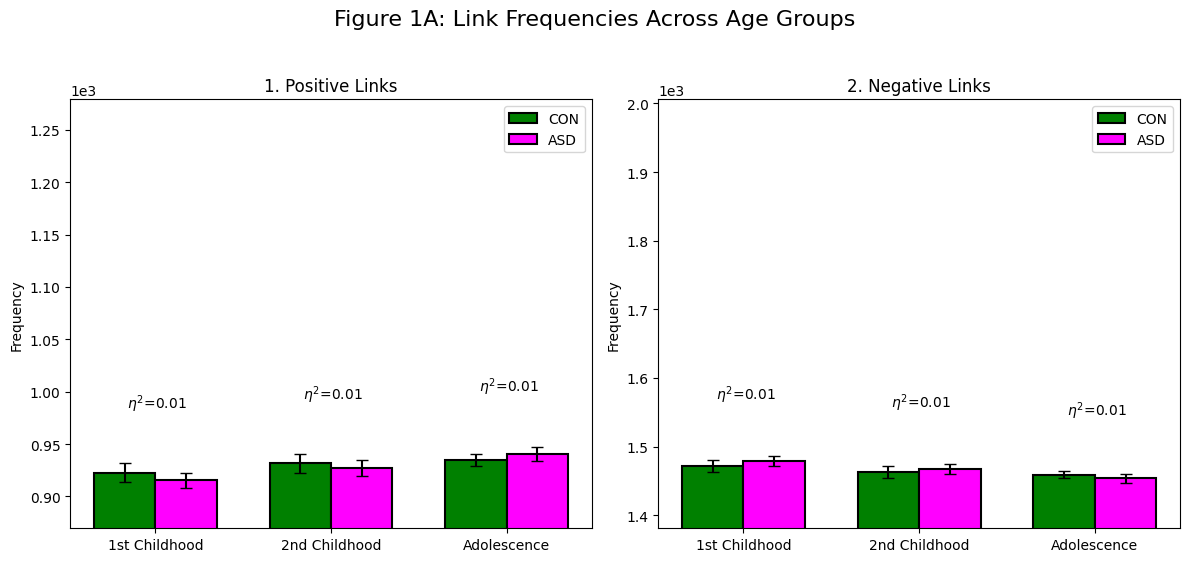

In [11]:
# --- [Cell 7: Generate Figure 1A (Link Frequencies)] ---

# Ensure the harmonized df_analysis and post-hoc stats are loaded from previous cells
if 'df_analysis' not in locals() or 'post_hoc_p_values' not in locals():
    raise NameError("DataFrames not found. Please run the data loading and statistics cells first.")

# --- Plotting Setup ---
# Define the specific metrics and titles for this figure
link_metrics = ['pos_links', 'neg_links']
link_titles = {'pos_links': '1. Positive Links', 'neg_links': '2. Negative Links'}
age_order = ['1st Childhood', '2nd Childhood', 'Adolescence']

# Create a 1x2 subplot grid (one plot for positive, one for negative links)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten() # Flatten the axes array for easy iteration

# Loop through each metric to create a subplot
for i, metric in enumerate(link_metrics):
    # For each metric, group the data by Age and Group to calculate mean and standard error
    df_bar = df_analysis.groupby(["AgeGroup", "Group"], observed=True)[metric].agg(['mean', 'sem']).reset_index()
    
    # --- Manual Bar and Error Bar Plotting ---
    x = np.arange(len(age_order))  # the x-axis tick locations (0, 1, 2)
    width = 0.35  # the width of each bar
    
    # Prepare the data for each group (CON and ASD)
    con_means = df_bar[df_bar['Group'] == 'CON']['mean']
    asd_means = df_bar[df_bar['Group'] == 'ASD']['mean']
    con_sem = df_bar[df_bar['Group'] == 'CON']['sem']
    asd_sem = df_bar[df_bar['Group'] == 'ASD']['sem']

    # Plot the bars with manual offsets for side-by-side comparison
    axes[i].bar(x - width/2, con_means, width, label='CON', color='green', edgecolor='black', linewidth=1.5)
    axes[i].bar(x + width/2, asd_means, width, label='ASD', color='magenta', edgecolor='black', linewidth=1.5)

    # Add error bars, ensuring they are centered on the new bar positions
    axes[i].errorbar(x - width/2, con_means, yerr=con_sem, fmt='none', c='black', capsize=4)
    axes[i].errorbar(x + width/2, asd_means, yerr=asd_sem, fmt='none', c='black', capsize=4)
    
    # Add statistical annotations to each age group on the plot
    for j, age in enumerate(age_order):
        if metric in post_hoc_eta2 and age in post_hoc_eta2[metric]:
            eta2 = post_hoc_eta2[metric][age]
            p_val = post_hoc_p_values[metric][age]
            # Determine significance level for p-value
            sig = '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            
            # Position the text above the taller of the two bars for that age group
            max_mean_plus_sem = (df_bar.loc[df_bar['AgeGroup'] == age, 'mean'] + df_bar.loc[df_bar['AgeGroup'] == age, 'sem']).max()
            axes[i].text(j, max_mean_plus_sem * 1.05, f'{sig} $\\eta^2$={eta2:.2f}', ha='center', va='bottom', fontsize=10)

    # Adjust y-axis limits to "zoom in" on the data and provide space for annotations
    if not df_bar.empty:
        min_val = df_bar['mean'].min()
        max_y_val = (df_bar['mean'] + df_bar['sem']).max()
        axes[i].set_ylim(min_val * 0.95, max_y_val * 1.35)

    # Set titles, labels, and ticks for the subplot
    axes[i].set_title(link_titles[metric], fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(age_order)
    axes[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axes[i].legend()

# --- Final Figure Formatting ---
plt.suptitle("Figure 1A: Link Frequencies Across Age Groups", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to prevent overlap

# Save the final figure to the output directory
plt.savefig(os.path.join(OUTPUT_DIR_KAGGLE, 'figure_1A_links_final.png'), dpi=300, bbox_inches='tight')
plt.show()



## Cell 8: Generate Figure 1B (Triad Frequencies)

In this cell, I create the second part of Figure 1 from the paper, which visualizes the mean frequencies of the four different triad types ($T_0, T_1, T_2, T_3$) across the developmental age groups.

The process for each subplot is as follows:
1.  I group my final harmonized `df_analysis` DataFrame to get the mean and standard error of the mean (SEM) for each group and age.
2.  I use `matplotlib`'s `bar` function to manually plot the bars for the CON and ASD groups. This gives me precise control over their width and position, ensuring the error bars are perfectly centered.
3.  I then plot the corresponding error bars (representing the SEM) on each bar.
4.  Finally, I add the statistical annotations (`p-value` stars and `η²` effect size) that I calculated in the post-hoc statistics cell. The y-axis limits are adjusted to zoom in on the data and make group differences more apparent.

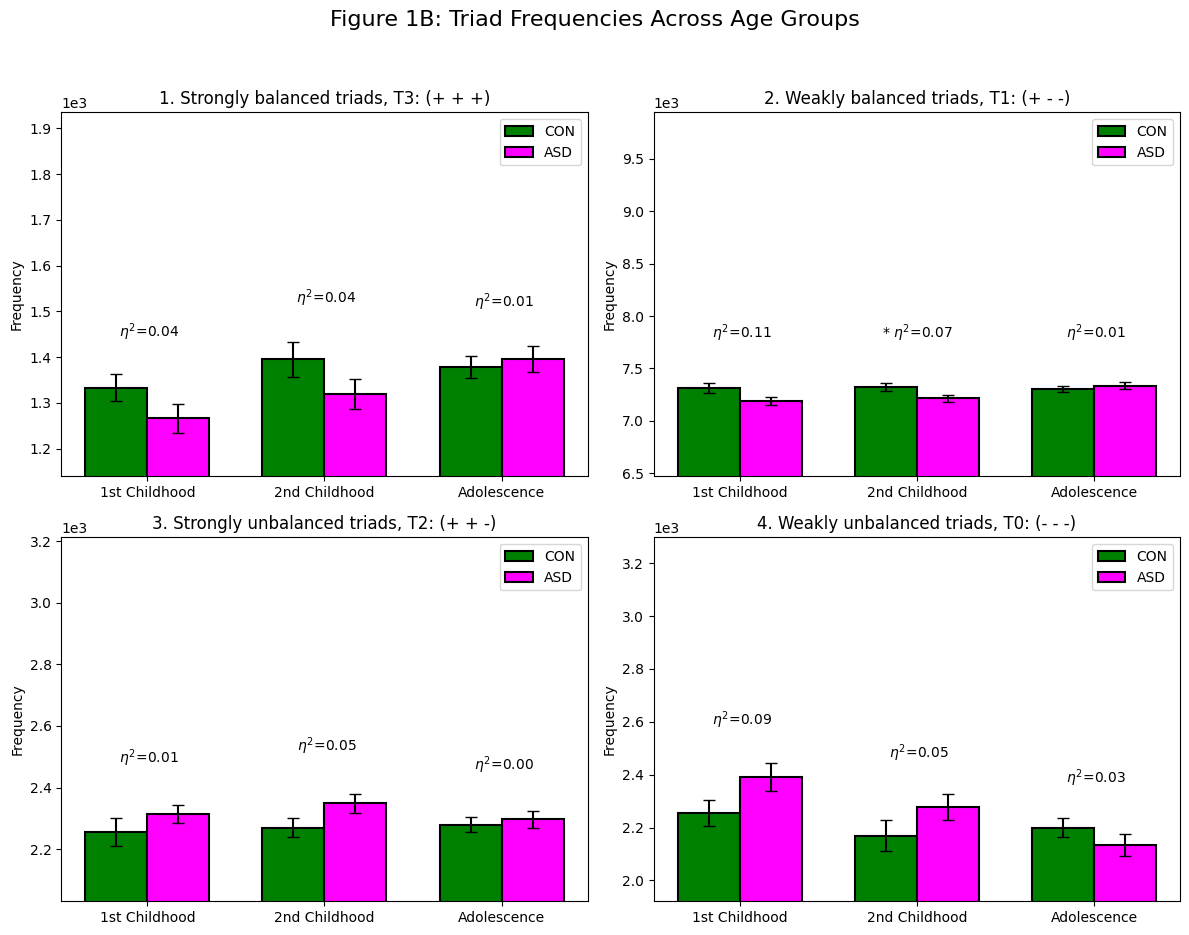

In [12]:
# --- [Cell 8: Generate Figure 1B (Triad Frequencies)] 

# Ensure the harmonized df_analysis and post-hoc stats are loaded from previous cells
if 'df_analysis' not in locals() or 'post_hoc_p_values' not in locals():
    raise NameError("DataFrames not found. Please run the data loading and statistics cells first.")

# --- Plotting Setup ---
# Define the specific metrics and titles for this figure
triad_metrics = ['T3', 'T1', 'T2', 'T0']
triad_titles = {
    'T3': '1. Strongly balanced triads, T3: (+ + +)', 'T1': '2. Weakly balanced triads, T1: (+ - -)',
    'T2': '3. Strongly unbalanced triads, T2: (+ + -)', 'T0': '4. Weakly unbalanced triads, T0: (- - -)'
}
age_order = ['1st Childhood', '2nd Childhood', 'Adolescence']

# Create a 2x2 subplot grid for the four triad types
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten() # Flatten the 2x2 array of axes for easy iteration

# Loop through each metric to create a subplot
for i, metric in enumerate(triad_metrics):
    # For each metric, group the data by Age and Group to calculate mean and standard error
    df_bar = df_analysis.groupby(["AgeGroup", "Group"], observed=True)[metric].agg(['mean', 'sem']).reset_index()

    # --- Manual Bar and Error Bar Plotting ---
    x = np.arange(len(age_order))  # the x-axis tick locations (0, 1, 2)
    width = 0.35  # the width of each individual bar
    
    # Prepare the data for each group (CON and ASD)
    con_means = df_bar[df_bar['Group'] == 'CON']['mean']
    asd_means = df_bar[df_bar['Group'] == 'ASD']['mean']
    con_sem = df_bar[df_bar['Group'] == 'CON']['sem']
    asd_sem = df_bar[df_bar['Group'] == 'ASD']['sem']
    
    # Plot the bars with manual offsets for side-by-side comparison
    axes[i].bar(x - width/2, con_means, width, label='CON', color='green', edgecolor='black', linewidth=1.5)
    axes[i].bar(x + width/2, asd_means, width, label='ASD', color='magenta', edgecolor='black', linewidth=1.5)

    # Add error bars, ensuring they are centered on the new bar positions
    axes[i].errorbar(x - width/2, con_means, yerr=con_sem, fmt='none', c='black', capsize=4)
    axes[i].errorbar(x + width/2, asd_means, yerr=asd_sem, fmt='none', c='black', capsize=4)

    # Add statistical annotations to each age group on the plot
    for j, age in enumerate(age_order):
        if metric in post_hoc_eta2 and age in post_hoc_eta2[metric]:
            eta2 = post_hoc_eta2[metric][age]
            p_val = post_hoc_p_values[metric][age]
            # Determine significance level for p-value
            sig = '**' if p_val < 0.01 else '*' if p_val < 0.05 else ''
            
            # Position the text above the taller of the two bars for that age group
            max_mean_plus_sem = (df_bar.loc[df_bar['AgeGroup'] == age, 'mean'] + df_bar.loc[df_bar['AgeGroup'] == age, 'sem']).max()
            axes[i].text(j, max_mean_plus_sem * 1.05, f'{sig} $\\eta^2$={eta2:.2f}', ha='center', va='bottom', fontsize=10)

    # Adjust y-axis limits to "zoom in" on the data and provide space for annotations
    if not df_bar.empty:
        min_val = df_bar['mean'].min()
        max_y_val = (df_bar['mean'] + df_bar['sem']).max()
        axes[i].set_ylim(min_val * 0.9, max_y_val * 1.35)

    # Set titles, labels, and ticks for the subplot
    axes[i].set_title(triad_titles[metric], fontsize=12)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(age_order)
    axes[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    # Add a legend to each subplot for clarity
    axes[i].legend()

# --- Final Figure Formatting ---
plt.suptitle("Figure 1B: Triad Frequencies Across Age Groups", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to prevent overlap

# Save the final figure to the output directory
plt.savefig(os.path.join(OUTPUT_DIR_KAGGLE, 'figure_1B_triads_final.png'), dpi=300, bbox_inches='tight')
plt.show()

## Cell 9: Generate Figure 2A (Energy Distributions)

In this cell, I create the plots for Figure 2A from the paper, which visualizes the energy distributions of $T_1$ and $T_0$ triads for subjects in the "1st Childhood" age group.

The process for each subplot is as follows:
1.  I load the lists of individual, continuous triad energies that I saved as separate `.npy` files during the main data processing step. This is done for both the ASD and CON groups.
2.  I create histograms of these energy values using logarithmically spaced bins to capture the wide range of data. This gives me the count of triads (`|Tᵢ|`) within each energy bin.
3.  I use `matplotlib`'s `loglog` plot type to visualize the results. This correctly scales both the x-axis (Energy) and y-axis (Counts) logarithmically, matching the style of the paper's figure.
4.  I also include a helper function to calculate the **Kullback-Leibler (KL) Divergence**, which is a statistical measure of how different the ASD and CON energy distributions are. This calculated value is then added as an annotation to the plot.

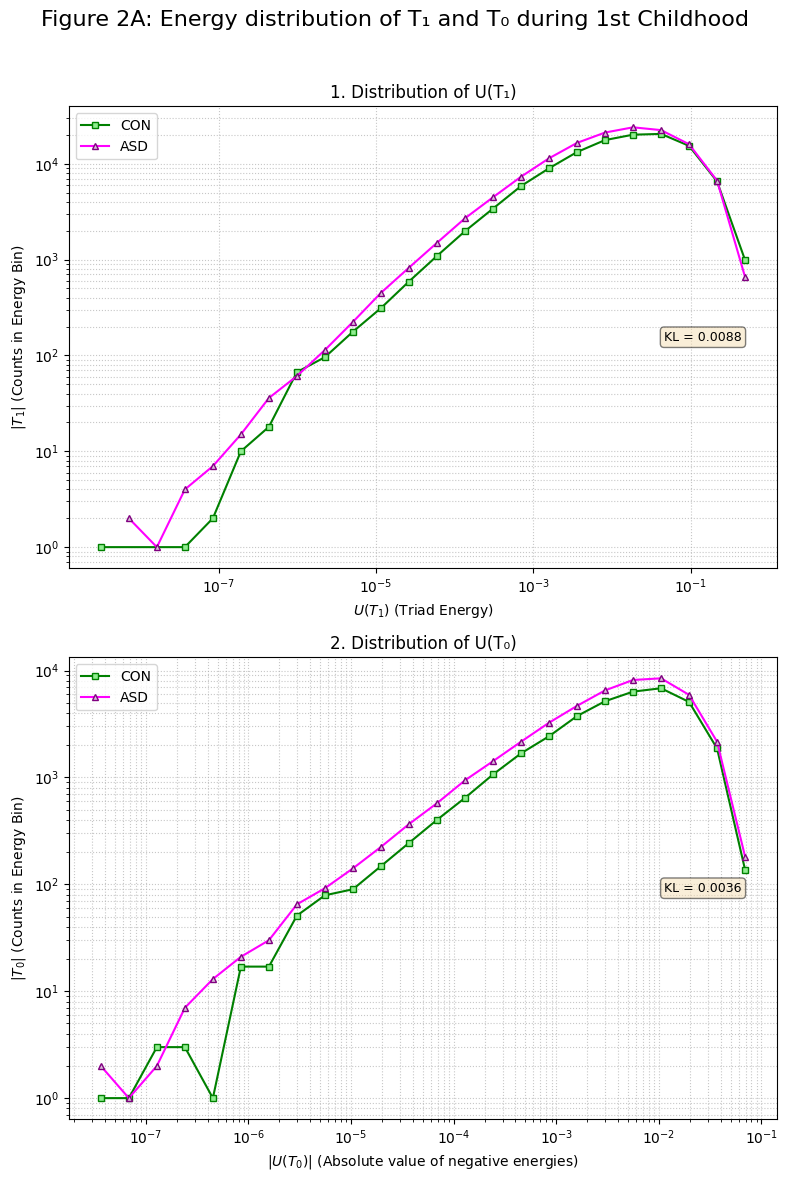

In [14]:
# --- [Cell 9: Generate Figure 2A (Energy Distributions)] ---

# Ensure the harmonized df_analysis is loaded to get the subject lists for filtering
if 'df_analysis' not in locals():
    raise NameError("df_analysis not found. Please load the final DataFrame first.")

# --- Helper function to calculate Symmetrized KL Divergence ---
def kl_divergence(p, q):
    """Calculates the symmetrized KL divergence between two probability distributions."""
    # Add a very small number (epsilon) to avoid division by zero or log(0) errors
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    
    # Calculate KL divergence from P to Q and from Q to P
    kl_pq = np.sum(p * np.log(p / q))
    kl_qp = np.sum(q * np.log(q / p))
    
    # The symmetrized KL divergence is the sum of the two
    return kl_pq + kl_qp

# Filter the main DataFrame to get only the subjects in the "1st Childhood" age group
df_1st_childhood = df_analysis[df_analysis['AgeGroup'] == '1st Childhood'].copy()

if df_1st_childhood.empty:
    print("No data available for '1st Childhood' to plot Figure 2A.")
else:
    # --- Plotting Setup ---
    fig, axes = plt.subplots(2, 1, figsize=(8, 12))
    plt.subplots_adjust(hspace=0.4)

    # --- Plot 1: Log-log Distribution of U(T1) ---
    ax = axes[0]
    # Load all T1 energy lists from their separate .npy files for each group
    all_t1_con = [e for sid in df_1st_childhood[df_1st_childhood['Group']=='CON']['SUB_ID'] for e in np.load(os.path.join(ENERGY_LISTS_DIR, f"{sid}_T1_unharm.npy")) if e > 0]
    all_t1_asd = [e for sid in df_1st_childhood[df_1st_childhood['Group']=='ASD']['SUB_ID'] for e in np.load(os.path.join(ENERGY_LISTS_DIR, f"{sid}_T1_unharm.npy")) if e > 0]
    
    if all_t1_con or all_t1_asd:
        # Create logarithmically spaced bins for the histogram
        min_val = min(all_t1_con + all_t1_asd) if (all_t1_con + all_t1_asd) else 0.001
        max_val = max(all_t1_con + all_t1_asd) if (all_t1_con + all_t1_asd) else 1.0
        log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 25)

        # Calculate histograms (counts of triads per energy bin) for each group
        counts_con, _ = np.histogram(all_t1_con, bins=log_bins)
        counts_asd, _ = np.histogram(all_t1_asd, bins=log_bins)
        # Find the center of each bin for plotting on the x-axis
        bin_centers = (log_bins[:-1] + log_bins[1:]) / 2

        # Convert counts to probabilities to calculate KL divergence
        prob_con = counts_con / np.sum(counts_con) if np.sum(counts_con) > 0 else np.zeros_like(counts_con)
        prob_asd = counts_asd / np.sum(counts_asd) if np.sum(counts_asd) > 0 else np.zeros_like(counts_asd)
        kl_t1 = kl_divergence(prob_con, prob_asd)

        # Use ax.loglog() to create a true log-log plot
        ax.loglog(bin_centers[counts_con > 0], counts_con[counts_con > 0],
                  marker='s', linestyle='-', color='green', label='CON', markersize=5, mfc='lightgreen', mec='green')
        ax.loglog(bin_centers[counts_asd > 0], counts_asd[counts_asd > 0],
                  marker='^', linestyle='-', color='magenta', label='ASD', markersize=5, mfc='thistle', mec='purple')
        
        ax.set_title('1. Distribution of U(T₁)')
        ax.set_xlabel('$U(T_{1})$ (Triad Energy)')
        ax.set_ylabel('$|T_{1}|$ (Counts in Energy Bin)')
        ax.text(0.95, 0.5, f'KL = {kl_t1:.4f}', ha='right', va='center', transform=ax.transAxes, fontsize=9, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

    # --- Plot 2: Log-log Distribution of U(T0) ---
    ax = axes[1]
    # Load T0 energy lists, taking the absolute value of the negative energies
    all_t0_con_abs = [abs(e) for sid in df_1st_childhood[df_1st_childhood['Group']=='CON']['SUB_ID'] for e in np.load(os.path.join(ENERGY_LISTS_DIR, f"{sid}_T0_unharm.npy")) if e < 0]
    all_t0_asd_abs = [abs(e) for sid in df_1st_childhood[df_1st_childhood['Group']=='ASD']['SUB_ID'] for e in np.load(os.path.join(ENERGY_LISTS_DIR, f"{sid}_T0_unharm.npy")) if e < 0]

    if all_t0_con_abs or all_t0_asd_abs:
        min_val = min(all_t0_con_abs + all_t0_asd_abs) if (all_t0_con_abs + all_t0_asd_abs) else 0.001
        max_val = max(all_t0_con_abs + all_t0_asd_abs) if (all_t0_con_abs + all_t0_asd_abs) else 1.0
        log_bins = np.logspace(np.log10(min_val), np.log10(max_val), 25)

        counts_con, _ = np.histogram(all_t0_con_abs, bins=log_bins)
        counts_asd, _ = np.histogram(all_t0_asd_abs, bins=log_bins)
        bin_centers = (log_bins[:-1] + log_bins[1:]) / 2
        
        # Convert to probabilities and calculate KL divergence for T0
        prob_con = counts_con / np.sum(counts_con) if np.sum(counts_con) > 0 else np.zeros_like(counts_con)
        prob_asd = counts_asd / np.sum(counts_asd) if np.sum(counts_asd) > 0 else np.zeros_like(counts_asd)
        kl_t0 = kl_divergence(prob_con, prob_asd)
        
        ax.loglog(bin_centers[counts_con > 0], counts_con[counts_con > 0],
                  marker='s', linestyle='-', color='green', label='CON', markersize=5, mfc='lightgreen', mec='green')
        ax.loglog(bin_centers[counts_asd > 0], counts_asd[counts_asd > 0],
                  marker='^', linestyle='-', color='magenta', label='ASD', markersize=5, mfc='thistle', mec='purple')

        ax.set_title('2. Distribution of U(T₀)')
        ax.set_xlabel('$|U(T_{0})|$ (Absolute value of negative energies)')
        ax.set_ylabel('$|T_{0}|$ (Counts in Energy Bin)')
        ax.text(0.95, 0.5, f'KL = {kl_t0:.4f}', ha='right', va='center', transform=ax.transAxes, fontsize=9, bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

    # Add shared formatting to both subplots
    for ax in axes:
        ax.legend()
        ax.grid(True, which="both", linestyle=':', alpha=0.7)

    # --- Final Figure Formatting ---
    fig.suptitle('Figure 2A: Energy distribution of T₁ and T₀ during 1st Childhood', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(OUTPUT_DIR_KAGGLE, 'figure_2A_final_logscale.png'), dpi=300)
    plt.show()



## Cell 10: Generate Figure 3 (Network Energy Box Plots)

In this cell, I create the plots for Figure 3 from the paper, which visualizes the network energy levels for the whole brain and for two key sub-networks: the Salience Network (SN) and the Default Mode Network (DMN).

The purpose of this figure is to compare the overall structural balance energy (`U(N)`) between the ASD and CON groups across the three developmental age ranges. The process for creating the figure is as follows:

1.  I load my final harmonized `df_analysis` DataFrame.
2.  I create a 1x3 grid of subplots for plots A, B, and C.
3.  For each subplot, I use `seaborn`'s `boxplot` function to visualize the distribution of energy values for each group and age. The box shows the median and interquartile range, while the whiskers and outlier points show the spread of the data.
4.  I add titles and labels to make the plots clear and comparable to the paper's figure.

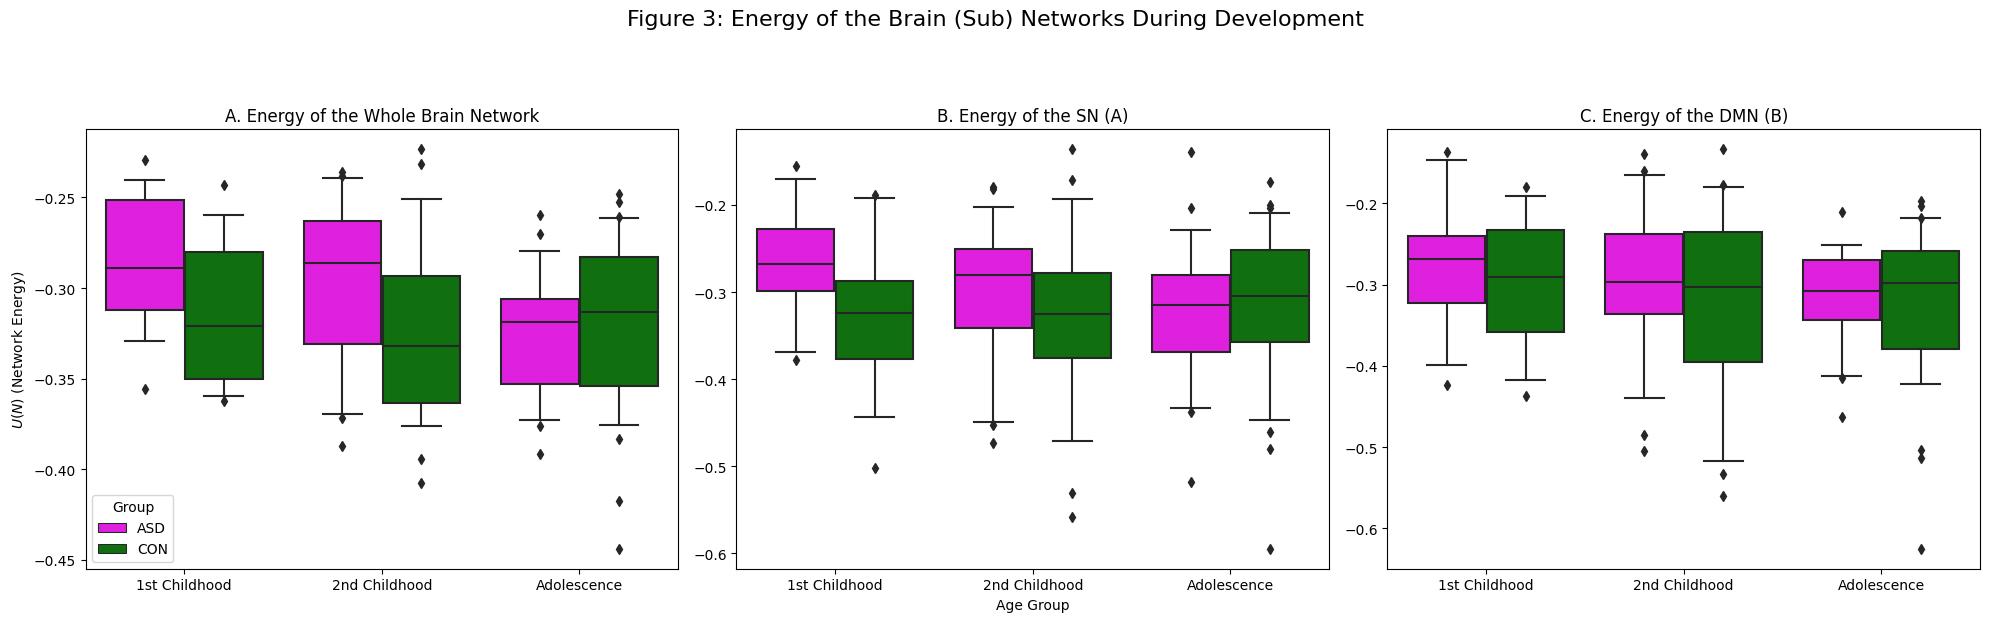

In [15]:
# --- [Cell 10: Generate Figure 3 (Network Energy Box Plots)] ---

# Ensure the harmonized df_analysis is loaded from a previous cell
if 'df_analysis' not in locals():
    # Attempt to load it if it's not in memory
    try:
        df_analysis = pd.read_pickle(os.path.join(OUTPUT_DIR_KAGGLE, 'df_analysis_final_unharmonized.pkl'))
        print("Successfully loaded the final unharmonized DataFrame.")
        # Re-apply categorical order if loaded from pickle, which is important for plotting
        age_order = ['1st Childhood', '2nd Childhood', 'Adolescence']
        df_analysis['AgeGroup'] = pd.Categorical(df_analysis['AgeGroup'], categories=age_order, ordered=True)
    except FileNotFoundError:
        raise NameError("df_analysis not found. Please run the main data processing cell first.")

# Check if all necessary columns for this figure exist in the DataFrame
required_cols = ['Energy_Whole_Brain', 'Energy_SN_A', 'Energy_DMN_B', 'AgeGroup', 'Group']
if not all(col in df_analysis.columns for col in required_cols):
    raise KeyError("DataFrame is missing required energy columns for Figure 3.")

# --- Plotting Setup ---
# Create a figure with a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
# Define the order for the x-axis categories
age_order = ['1st Childhood', '2nd Childhood', 'Adolescence']
# Define the color palette to match the paper (CON=green, ASD=magenta)
palette = {"CON": "green", "ASD": "magenta"}

# --- Plot A: Energy of the Whole Brain Network ---
ax = axes[0]
sns.boxplot(x='AgeGroup', y='Energy_Whole_Brain', hue='Group', data=df_analysis, ax=ax,
            palette=palette, order=age_order, 
            whis=[5, 95]) # Set whiskers to 5th and 95th percentiles to show outliers, similar to the paper
ax.set_title('A. Energy of the Whole Brain Network', fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('$U(N)$ (Network Energy)')
ax.legend(title='Group')


# --- Plot B: Energy of the SN (A) ---
ax = axes[1]
sns.boxplot(x='AgeGroup', y='Energy_SN_A', hue='Group', data=df_analysis, ax=ax,
            palette=palette, order=age_order, whis=[5, 95])
ax.set_title('B. Energy of the SN (A)', fontsize=12)
ax.set_xlabel('Age Group')
ax.set_ylabel('') # Remove redundant y-axis label
# Remove the legend from the middle plot to avoid clutter
if ax.get_legend() is not None: ax.get_legend().remove()


# --- Plot C: Energy of the DMN (B) ---
ax = axes[2]
sns.boxplot(x='AgeGroup', y='Energy_DMN_B', hue='Group', data=df_analysis, ax=ax,
            palette=palette, order=age_order, whis=[5, 95])
ax.set_title('C. Energy of the DMN (B)', fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('') # Remove redundant y-axis label
if ax.get_legend() is not None: ax.get_legend().remove()

# --- Final Figure Formatting ---
plt.suptitle('Figure 3: Energy of the Brain (Sub) Networks During Development', fontsize=16, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
# Save the final figure to the output directory
plt.savefig(os.path.join(OUTPUT_DIR_KAGGLE, 'figure_3_final.png'), dpi=300, bbox_inches='tight')
plt.show()



## Cell 11: Generate Figure 4 (Correlations with Behavioral Scores)

In this cell, I create the scatter plots for Figure 4 from the paper. This figure explores the relationship between the network energy metrics I calculated and various clinical behavioral scores (from ADOS and ADI).

The process for creating this figure is as follows:
1.  I first load my final, clean `df_analysis_final_harmonized.pkl` DataFrame.
2.  I then load the original `Phenotypic_V1_0b_preprocessed1.csv` file and merge the necessary behavioral score columns into my main DataFrame. This step also includes cleaning the data by replacing the `-9999` missing value placeholders with `NaN`.
3.  I create a 2x3 grid of subplots, one for each correlation shown in the paper.
4.  For each subplot, I filter the data for the correct age group and drop any subjects with missing values for that specific comparison.
5.  I then plot the data as a scatter plot with an overlaid regression line.
6.  Finally, I calculate the **Pearson correlation coefficient (`r`)** and the **p-value** directly from my data and add these statistics as an annotation onto each subplot.

Successfully loaded the final unharmonized DataFrame.
Replaced -9999 placeholders with NaN for accurate analysis.


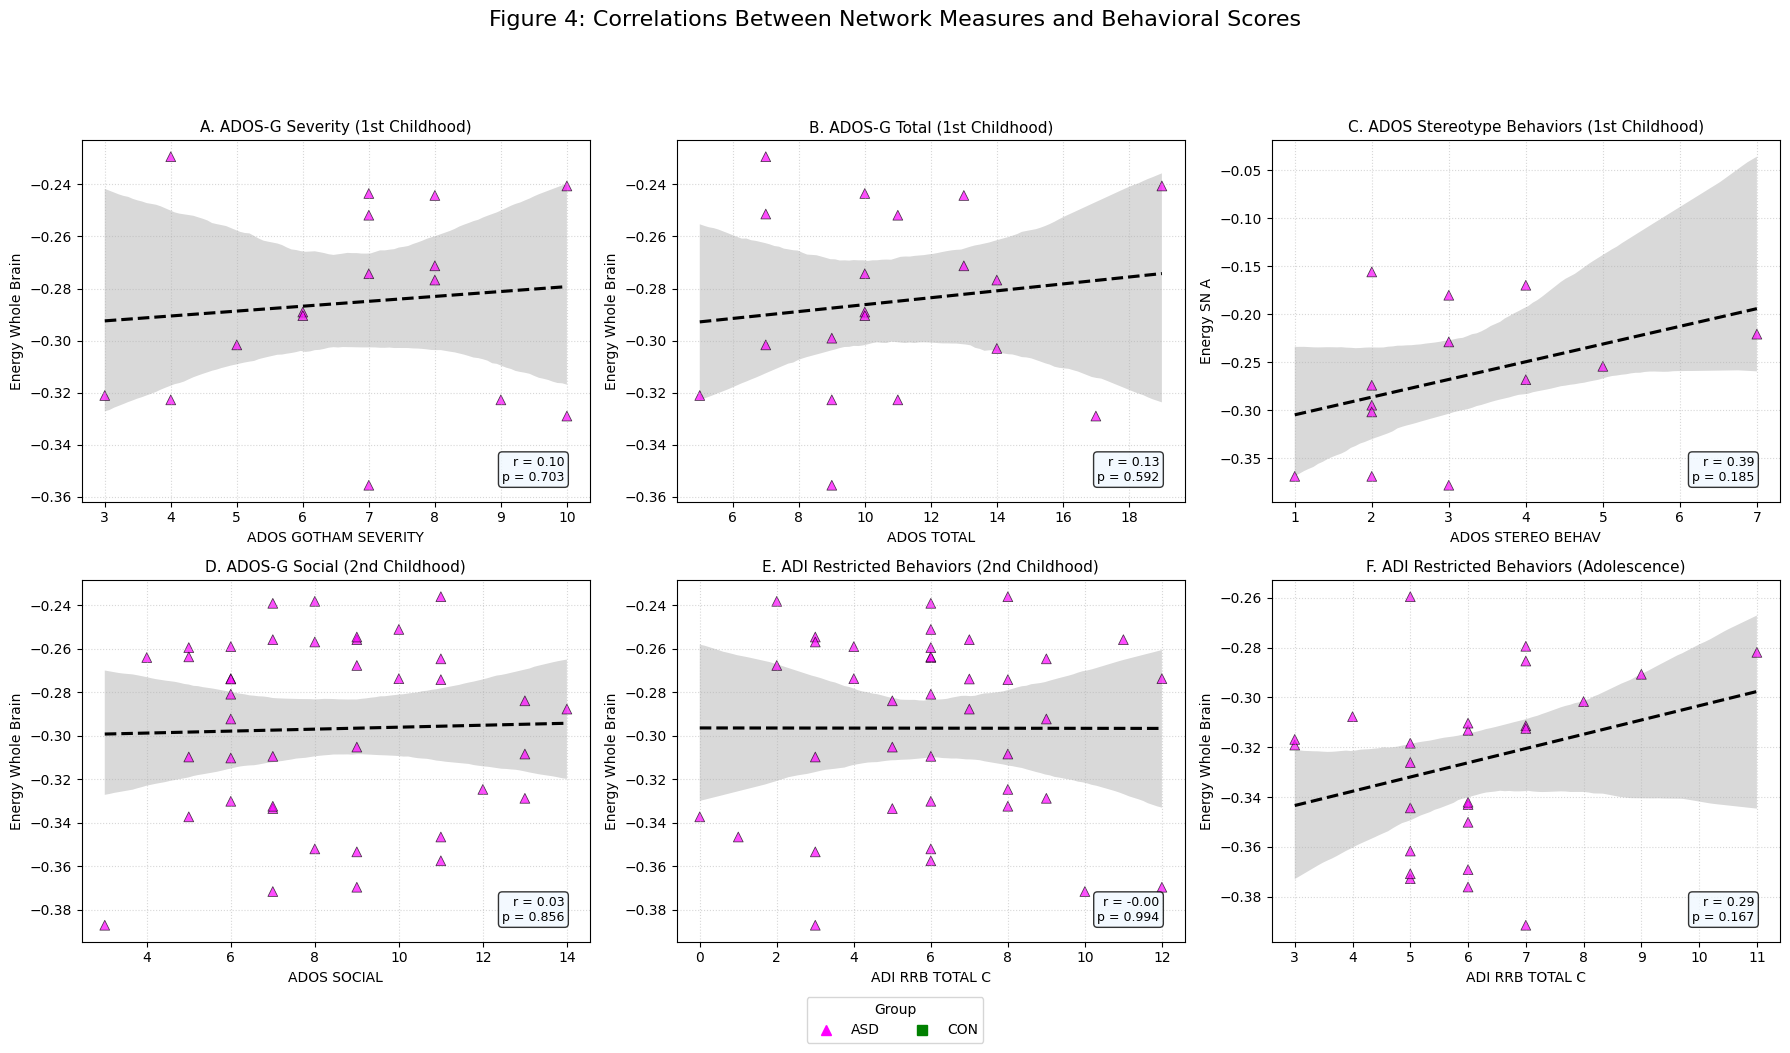

In [22]:
# --- [Cell 11: Generate Figure 4 (Correlations with Behavioral Scores)] ---
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import warnings

warnings.filterwarnings("ignore")

# --- 1. Define File Path ---
OUTPUT_DIR_KAGGLE = '/kaggle/working/'

# --- 2. Load Final DataFrame and Clean Data ---
try:
    # Load the final data which already contains all necessary columns
    data_path = os.path.join(OUTPUT_DIR_KAGGLE, 'df_analysis_final_unharmonized.pkl')
    df_analysis = pd.read_pickle(data_path)
    print("Successfully loaded the final unharmonized DataFrame.")

    # --- KEY DATA CLEANING STEP: Replace -9999 placeholders with NaN ---
    # List of all potential behavioral and covariate columns to clean
    cols_to_clean = [
        'FIQ', 'ADOS_GOTHAM_SEVERITY', 'ADOS_TOTAL', 
        'ADOS_STEREO_BEHAV', 'ADOS_SOCIAL', 'ADI_RRB_TOTAL_C'
    ]
    
    # Replace -9999 in all specified columns if they exist
    for col in cols_to_clean:
        if col in df_analysis.columns and pd.api.types.is_numeric_dtype(df_analysis[col]):
            df_analysis[col].replace(-9999, np.nan, inplace=True)
    print("Replaced -9999 placeholders with NaN for accurate analysis.")
    
except Exception as e:
    print(f"An error occurred during data loading or cleaning: {e}")


# --- 3. Define parameters for each of the 6 subplots with CORRECTED column names ---
plot_params = [
    {'x': 'ADOS_GOTHAM_SEVERITY', 'y': 'Energy_Whole_Brain', 'title': 'A. ADOS-G Severity', 'age': '1st Childhood'},
    {'x': 'ADOS_TOTAL', 'y': 'Energy_Whole_Brain', 'title': 'B. ADOS-G Total', 'age': '1st Childhood'},
    {'x': 'ADOS_STEREO_BEHAV', 'y': 'Energy_SN_A', 'title': 'C. ADOS Stereotype Behaviors', 'age': '1st Childhood'},
    {'x': 'ADOS_SOCIAL', 'y': 'Energy_Whole_Brain', 'title': 'D. ADOS-G Social', 'age': '2nd Childhood'},
    {'x': 'ADI_RRB_TOTAL_C', 'y': 'Energy_Whole_Brain', 'title': 'E. ADI Restricted Behaviors', 'age': '2nd Childhood'},
    {'x': 'ADI_RRB_TOTAL_C', 'y': 'Energy_Whole_Brain', 'title': 'F. ADI Restricted Behaviors', 'age': 'Adolescence'}
]

# --- 4. Plotting Setup ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.subplots_adjust(hspace=0.45, wspace=0.3)
axes = axes.flatten()

# --- 5. Main Plotting Loop ---
for i, params in enumerate(plot_params):
    ax = axes[i]
    
    # Check if required columns for this subplot exist
    if params['x'] not in df_analysis.columns or params['y'] not in df_analysis.columns:
        ax.text(0.5, 0.5, f"Missing column:\n{params['x']} or {params['y']}", ha='center', va='center', color='red')
        ax.set_title(f"{params['title']} ({params['age']})", fontsize=11)
        continue

    # Filter data for the specific age group and drop rows with missing values for the plotting columns
    df_subset = df_analysis[df_analysis['AgeGroup'] == params['age']].copy()
    df_subset.dropna(subset=[params['x'], params['y']], inplace=True)
    
    if not df_subset.empty:
        sns.regplot(x=params['x'], y=params['y'], data=df_subset, ax=ax,
                    scatter_kws={'s': 0}, line_kws={'color': 'black', 'linestyle': '--'})
        
        sns.scatterplot(x=params['x'], y=params['y'], hue='Group', style='Group', 
                        data=df_subset, ax=ax,
                        palette={'ASD': 'magenta', 'CON': 'green'}, markers={'ASD': '^', 'CON': 's'},
                        s=50, alpha=0.7, edgecolor='k', legend=False)

        # Calculate Pearson correlation from the data
        r_val, p_val = pearsonr(df_subset[params['x']], df_subset[params['y']])
        
        ax.text(0.95, 0.05, f'r = {r_val:.2f}\np = {p_val:.3f}',
                ha='right', va='bottom', transform=ax.transAxes, fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.8))
    else:
        ax.text(0.5, 0.5, "No valid data points", ha='center', va='center', transform=ax.transAxes)

    ax.set_title(f"{params['title']} ({params['age']})", fontsize=11)
    ax.set_xlabel(params['x'].replace('_', ' '))
    ax.set_ylabel(params['y'].replace('_', ' '))
    ax.grid(True, linestyle=':', alpha=0.5)

# --- 6. Final Figure Formatting ---
fig.suptitle('Figure 4: Correlations Between Network Measures and Behavioral Scores', fontsize=16, y=1.02)
handles, labels = [], []
if any(ax.has_data() for ax in axes):
    import matplotlib.lines as mlines
    handles = [
        mlines.Line2D([], [], color='magenta', marker='^', linestyle='None', markersize=7, label='ASD'),
        mlines.Line2D([], [], color='green', marker='s', linestyle='None', markersize=7, label='CON')
    ]
    labels = ['ASD', 'CON']
    fig.legend(handles, labels, loc='lower center', ncol=2, title="Group", bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# Save to file
plt.savefig(os.path.join(OUTPUT_DIR_KAGGLE, 'figure_4_final_unharmonized.png'), dpi=300, bbox_inches='tight')
plt.show()

